# W2 Dataset Preprocessing

**Introduction**:

The purpose of this notebook is to perform dataset preprocessing for the downstream notebooks involving model inference and training. 

Steps: 
  - Bootstrap the environment
  - Download and filter on the "clean" dataset involving relatively pristine w2 examples
  - Convert PDFs to images
  - Explore, filter, clean, and convert the raw ground truth examples (saved in an Excel spreadsheet) into .jsonl format, useful for inference and training with HuggingFace
  - Split the final dataset into train, validation, and test datasets

Follow the project README for more info on running this notebook. 

# Bootstrap Environment


In [ ]:
# Set working directory
import os
os.environ["APP_PROJECT_DIR"] = "/content/ai-image-to-text"  # override with project directory
os.chdir(os.environ["APP_PROJECT_DIR"])

# Install packages and bootstrap environment
%pip install -q python-dotenv
from src.utils.env_setup import setup_environment
env = setup_environment()
%pip install -q -r requirements-{env}.txt

Note: you may need to restart the kernel to use updated packages.
Loaded application properties from: /Users/admin/workspace/ai-image-to-text/.env.local
Working directory: /Users/admin/workspace/ai-image-to-text
Note: you may need to restart the kernel to use updated packages.


In [62]:
import os
import pandas as pd
import kagglehub
import shutil, zipfile
import fitz
import json
from src.utils import w2_dataset, file
from collections import defaultdict
import random
from IPython.display import Image, display

# dataset constants
w2_dataset_name = "mcvishnu1/fake-w2-us-tax-form-dataset"
w2_dataset_zip_filename = "W2_Multi_Clean_DataSet_02.ZIP"
w2_dataset_labels_filename = "W2_Truth_and_Noise_DataSet_02.xlsx"
w2_dataset_zip_out_dirname = "w2_samples_multi_clean"
w2_dataset_labels_sheet_name = "TruthData"
w2_dataset_filename_feature_name = "File_BaseName"

# file and directory paths
base_dir = os.environ["APP_PROJECT_DIR"]
datasets_dir = os.environ["APP_DATA_DIR"]
dataset_w2s_dir = f"{datasets_dir}/w2s"
dataset_raw_dir = f"{dataset_w2s_dir}/raw"
dataset_raw_pdfs_dir = f"{dataset_raw_dir}/pdfs"
dataset_raw_labels_file = f"{dataset_raw_dir}/{w2_dataset_labels_filename}"
dataset_processed_dir = f"{dataset_w2s_dir}/processed"
dataset_processed_images_dir = f"{dataset_processed_dir}/images"
dataset_processed_labels_file = f"{dataset_processed_dir}/metadata.jsonl"
dataset_processed_final_dir = f"{dataset_processed_dir}/final"

# general constants
random_state = 42
dpi_setting = 300
image_size = [720, 960]
max_length = 512
ignore_id = -100

# Preprocess Kaggle w-2 dataset

Download and extract the fake w-2 dataset from Kaggle. Load the spreadsheet metadata, representing the ground truth labels from the dataset.

In [7]:
# download the w-2 dataset from kaggle
path = kagglehub.dataset_download(w2_dataset_name, force_download=False)

# create destination folders
os.makedirs(dataset_raw_dir, exist_ok=True)

# copy "multi clean" dataset to working datasets directory
shutil.copy2(f"{path}/{w2_dataset_zip_filename}", f"{dataset_raw_dir}")
shutil.copy2(f"{path}/{w2_dataset_labels_filename}", f"{dataset_raw_dir}")

# extract zip
with zipfile.ZipFile(f"{dataset_raw_dir}/{w2_dataset_zip_filename}", "r") as zip_ref:
    zip_ref.extractall(dataset_raw_dir)

# rename zip extraction folder and clean up
os.rename(f"{dataset_raw_dir}/{w2_dataset_zip_out_dirname}", dataset_raw_pdfs_dir)
os.remove(f"{dataset_raw_dir}/{w2_dataset_zip_filename}")
print(f"Dataset extracted to {dataset_raw_dir}")

Dataset extracted to /Users/admin/workspace/ai-image-to-text/.datasets/w2s/raw


Convert .pdf files to .png images. This can take a few minutes.

In [8]:
# Create the output directory if it doesn’t exist
os.makedirs(dataset_processed_images_dir, exist_ok=True)

# Process each PDF file in the input directory
for filename in os.listdir(dataset_raw_pdfs_dir):

    # Ensure the item is a PDF file
    if filename.endswith(".pdf") and os.path.isfile(
        os.path.join(dataset_raw_pdfs_dir, filename)
    ):

        # Construct full path to the PDF
        pdf_path = os.path.join(dataset_raw_pdfs_dir, filename)

        # Open the PDF document
        doc = fitz.open(pdf_path)

        # Check if the document has at least one page
        if len(doc) > 0:

            # Get the first page
            page = doc[0]

            # Render the page as an image with specified DPI
            pix = page.get_pixmap(dpi=dpi_setting)

            # Create image filename by replacing .pdf with .png
            image_filename = os.path.splitext(filename)[0] + ".png"
            image_path = os.path.join(dataset_processed_images_dir, image_filename)

            # Save the image
            pix.save(image_path)

    # Close the document to free resources
    doc.close()

pdf_count = len([f for f in os.listdir(dataset_raw_pdfs_dir)])
image_count = len([f for f in os.listdir(dataset_processed_images_dir)])
print(f"Extracted {image_count} images from {pdf_count} PDF files.")
print(f"Destination directory: {dataset_processed_images_dir}")

Extracted 1000 images from 1000 PDF files.
Destination directory: /Users/admin/workspace/ai-image-to-text/.datasets/w2s/processed/images


Read ground truth labels.

In [63]:
# read image schema
df = pd.read_excel(
    f"{dataset_raw_dir}/{w2_dataset_labels_filename}",
    sheet_name=w2_dataset_labels_sheet_name,
)
df.head()

,File_BaseName,EIN,Employer's Name,Employer's Street Address,Employer's City-State-Zip,Employer's City,Employer's State,Employer's Zip,Employee Social Security Number,Employee Name,...,Local Wages & Tips_1,Local Income Tax_1,Locality Name_1,State_2,Employee State ID_2,"State wages, tips,etc_2",State Income Tax_2,Local Wages & Tips_2,Local Income Tax_2,Locality Name_2
0,W2_Multi_Sample_Data_input_ADP1_clean_15500,42-1019538,Lewis Ltd and Sons,034 Amanda Estate Suite 853,West Ariana UT 89727-6349,West Ariana,UT,89727-6349,480-47-6564,Tara Wilson,...,220807.76,21715.51,Andrew Drive,UT,174-24-042,89872.97,7450.37,222690.19,35467,Harvey Common
1,W2_Multi_Sample_Data_input_ADP1_clean_15501,13-6276191,Key-Hanna Ltd,088 Harper Ridge Apt. 889,Kellyberg NV 21899-4850,Kellyberg,NV,21899-4850,270-20-9541,Charles Mays,...,72467.14,9791.24,Maria Camp,VT,655-53-961,36282.32,4746.7,91425.02,13562.89,Hannah Squares
2,W2_Multi_Sample_Data_input_ADP1_clean_15502,48-9912881,Farrell Inc and Sons,53677 John Path Suite 242,Andersonbury MO 22613-7256,Andersonbury,MO,22613-7256,647-03-2689,Anthony Williams,...,50466.15,12232.41,Hubbard Harbor,CO,735-60-559,35225.06,1951.2,51123.62,12377.32,Catherine Lakes
3,W2_Multi_Sample_Data_input_ADP1_clean_15503,13-8284327,Ward Group LLC,52937 Campbell Camp,Lake Elizabethport TN 16620-8946,Lake Elizabethport,TN,16620-8946,129-55-0636,Cassie Green,...,207893.11,21420.63,Catherine Highway,TN,459-40-740,91320.47,4556.08,133006.99,23944.71,Munoz Square
4,W2_Multi_Sample_Data_input_ADP1_clean_15504,92-6720513,Roman-Murphy Group,8239 Jillian Landing Apt. 873,East Alisonborough CT 01890-5466,East Alisonborough,CT,01890-5466,429-42-3995,Matthew Potter,...,179072.14,33443.18,John Curve,PA,872-84-819,88424.57,3883.27,161929.61,24336.19,Romero Run


In [ ]:
# filter the dataframe to the fields relevant for income verfication (and the image filename)
key_fields = [
    w2_dataset_filename_feature_name,
    "Employee Name",
    "Wages, Tips & other Compensation",
    "Federal Income Tax Withheld",
    "Social Security Wages",
    "Medicare Wages & Tips",
    "State_1",
    "State wages, tips,etc_1",
    "State Income Tax_1",
    "State_2",
    "State wages, tips,etc_2",
    "State Income Tax_2",
    "Employer's Name",
]

# Filter the dataframe to include only the specified columns
df2 = df[key_fields]

# Move `Employer's Name` column after `Employee Name`
dest_col = df2.columns.get_loc("Employee Name")
src_col = df2.pop("Employer's Name")
df2.insert(dest_col + 1, src_col.name, src_col)

# Normalize column names
df2.columns = [
    w2_dataset_filename_feature_name,
    "Employee Name",
    "Employer Name",
    "Wages and Tips",
    "Federal Income Tax Withheld",
    "Social Security Wages",
    "Medicare Wages and Tips",
    "State 1",
    "State 1 Wages and Tips",
    "State 1 Income Tax Withheld",
    "State 2",
    "State 2 Wages and Tips",
    "State 2 Income Tax Withheld",
]

# Remove duplicated headers
df2 = df2[df2[w2_dataset_filename_feature_name] != w2_dataset_filename_feature_name]
df2 = df2.reset_index(drop=True)

# Format monetary columns to ensure two decimal places of precision
monetary_columns = [
    "Wages and Tips",
    "Federal Income Tax Withheld",
    "Social Security Wages",
    "Medicare Wages and Tips",
    "State 1 Wages and Tips",
    "State 1 Income Tax Withheld",
    "State 2 Wages and Tips",
    "State 2 Income Tax Withheld",
]
for col in monetary_columns:
    df2[col] = df2[col].apply(lambda x: f"{x:.2f}")

# Make all columns type str
df2 = df2.astype(str)

# Form types ADP1 and ADP2 don't contain state 2 fields (even though they should).
# This is a flaw in the dataset. Set values to empty strings for these form types.
state2_columns = ["State 2", "State 2 Wages and Tips", "State 2 Income Tax Withheld"]
mask = df2["File_BaseName"].apply(w2_dataset.get_w2_form_type).isin(["ADP1", "ADP2"])
df2.loc[mask, state2_columns] = ""

# Inspect results
start_indexes = [0, 250, 500, 750]
n_rows = 5
for start in start_indexes:
    end = min(start + n_rows, len(df2))
    if start < len(df2):
        display(df2.iloc[start:end].head())
        print()  # Blank line for readability

,File_BaseName,Employee Name,Employer Name,Wages and Tips,Federal Income Tax Withheld,Social Security Wages,Medicare Wages and Tips,State 1,State 1 Wages and Tips,State 1 Income Tax Withheld,State 2,State 2 Wages and Tips,State 2 Income Tax Withheld
0,W2_Multi_Sample_Data_input_ADP1_clean_15500,Tara Wilson,Lewis Ltd and Sons,193488.36,56204.7,144247.3,219880.52,WI,93120.37,6308.88,,,
1,W2_Multi_Sample_Data_input_ADP1_clean_15501,Charles Mays,Key-Hanna Ltd,79458.26,12679.4,70291.87,88849.06,NE,43279.27,5067.21,,,
2,W2_Multi_Sample_Data_input_ADP1_clean_15502,Anthony Williams,Farrell Inc and Sons,64460.79,12287.69,56179.43,77647.69,SD,30114.75,2227.38,,,
3,W2_Multi_Sample_Data_input_ADP1_clean_15503,Cassie Green,Ward Group LLC,188899.98,21360.26,149706.4,204111.84,NH,91761.94,5781.84,,,
4,W2_Multi_Sample_Data_input_ADP1_clean_15504,Matthew Potter,Roman-Murphy Group,177627.99,39639.37,221555.93,211678.45,HI,89109.96,5312.92,,,


,File_BaseName,Employee Name,Employer Name,Wages and Tips,Federal Income Tax Withheld,Social Security Wages,Medicare Wages and Tips,State 1,State 1 Wages and Tips,State 1 Income Tax Withheld,State 2,State 2 Wages and Tips,State 2 Income Tax Withheld
250,W2_Multi_Sample_Data_input_ADP2_clean_20750,Kimberly Reed,Jacobson-Johnson Ltd,111650.02,11522.12,87000,78396,LA,51229.27,5065.22,,,
251,W2_Multi_Sample_Data_input_ADP2_clean_20751,Madison Campbell,Johnson-Singh PLC,83748.49,29395.7,92568.31,75045.5,NJ,39883.65,2888.96,,,
252,W2_Multi_Sample_Data_input_ADP2_clean_20752,Alexis Davis,Gray Inc Group,196740.39,70762.43,226974.05,141566.38,WI,107225.04,7852.92,,,
253,W2_Multi_Sample_Data_input_ADP2_clean_20753,Kristin Giles,Daniels Group PLC,198025.32,73034.03,221467.62,225397.86,OH,96204.44,5293.91,,,
254,W2_Multi_Sample_Data_input_ADP2_clean_20754,Ryan Paul,Mccarthy Group Group,136041.05,39569.46,108448.77,106341,ID,72220.3,4648.73,,,


,File_BaseName,Employee Name,Employer Name,Wages and Tips,Federal Income Tax Withheld,Social Security Wages,Medicare Wages and Tips,State 1,State 1 Wages and Tips,State 1 Income Tax Withheld,State 2,State 2 Wages and Tips,State 2 Income Tax Withheld
500,W2_Multi_Sample_Data_input_IRS1_clean_5000,Benjamin Burch,"Ward, Allison and Jimenez Inc",209665.25,53423.5,272174.17,225347.99,UT,101914.73,6744.55,MS,111269.12,7135.46
501,W2_Multi_Sample_Data_input_IRS1_clean_5001,Charlotte White,Wood-Turner and Sons,85353.33,10977.45,80852.11,61015.29,IL,41423.51,3817.61,NM,42198,4835.13
502,W2_Multi_Sample_Data_input_IRS1_clean_5002,Johnathan Wright,Welch and Sons PLC,191392.77,65673.92,176164.97,213131.6,IN,104114.62,9924.15,KY,91543.02,8400.9
503,W2_Multi_Sample_Data_input_IRS1_clean_5003,Bethany Ramos,Davis-Burke Group,58497.67,20301.91,68385.99,59287.95,DC,30160.66,3050.14,MT,32167.22,2624.17
504,W2_Multi_Sample_Data_input_IRS1_clean_5004,Kaitlin Campbell,Welch PLC LLC,76494.49,17846.68,98921.35,86050.92,OR,38583,4058.59,NJ,34722.88,4577.37


,File_BaseName,Employee Name,Employer Name,Wages and Tips,Federal Income Tax Withheld,Social Security Wages,Medicare Wages and Tips,State 1,State 1 Wages and Tips,State 1 Income Tax Withheld,State 2,State 2 Wages and Tips,State 2 Income Tax Withheld
750,W2_Multi_Sample_Data_input_IRS2_clean_10250,Michael Brady,White Group Ltd,169792.08,19693.19,179041.17,174894.52,WA,83340.7,5866.21,FL,78263.06,6178.72
751,W2_Multi_Sample_Data_input_IRS2_clean_10251,Mr. Charles,Carter-Lawrence and Sons,244230.68,85427.05,312549.82,177237.95,WV,119490.52,11084.49,NE,123779.04,13601.58
752,W2_Multi_Sample_Data_input_IRS2_clean_10252,Nicole Martinez,Morrison PLC and Sons,213781.63,48737.78,266557.21,199602.05,ME,114052.42,13686.21,MO,108297.61,12163.41
753,W2_Multi_Sample_Data_input_IRS2_clean_10253,Holly Smith,Hughes Ltd LLC,195388.95,26299.67,138523.57,201486.46,MI,105992.01,6976.92,OR,95161.86,6788.14
754,W2_Multi_Sample_Data_input_IRS2_clean_10254,Meagan Valdez,Hall-Robbins LLC,139498.74,34024.2,169160.38,140389.86,CA,69130.01,4710.39,SC,64811.77,5254.22


# Prepare ground truth metadata files

Convert structured data to a `metadata.jsonl` file. We'll store the ground truth samples as JSON objects.

In [65]:
def write_schema_to_metadata_file(dataframe, file_path):
    # create new dataframe that conforms to the necessary metadata.json format
    dataframe = pd.DataFrame(
        {
            "file_name": dataframe[w2_dataset_filename_feature_name] + ".png",
            "text": dataframe.drop(w2_dataset_filename_feature_name, axis=1).apply(
                lambda row: json.dumps(row.to_dict()), axis=1
            ),
        }
    )

    def collapse_spaces(s):
        return " ".join(s.split()) if isinstance(s, str) else s

    # remove any extraneous spaces from the JSON string
    def clean_json_text(json_str):
        data = json.loads(json_str)
        cleaned_data = {key: collapse_spaces(value) for key, value in data.items()}
        return json.dumps(cleaned_data)

    # Apply the cleaning function to the "text" column
    dataframe["text"] = dataframe["text"].apply(clean_json_text)

    # Write as JSON lines
    target_dir = os.path.dirname(file_path)
    if not os.path.exists(target_dir):
        os.makedirs(target_dir, exist_ok=True)
    dataframe.to_json(file_path, orient="records", lines=True)

    return dataframe


# write full metadata file
df3 = write_schema_to_metadata_file(df2, dataset_processed_labels_file)
print(f"metadata.jsonl written to {dataset_processed_labels_file}")

metadata.jsonl written to /Users/admin/workspace/ai-image-to-text/.datasets/w2s/processed/metadata.jsonl


Let's output an example to see the filtered-down ground truth fields and structure.

In [66]:
example = json.loads(df3.iloc[0]["text"])
print(json.dumps(example, indent=4))

{
    "Employee Name": "Tara Wilson",
    "Employer Name": "Lewis Ltd and Sons",
    "Wages and Tips": "193488.36",
    "Federal Income Tax Withheld": "56204.70",
    "Social Security Wages": "144247.30",
    "Medicare Wages and Tips": "219880.52",
    "State 1": "WI",
    "State 1 Wages and Tips": "93120.37",
    "State 1 Income Tax Withheld": "6308.88",
    "State 2": "",
    "State 2 Wages and Tips": "",
    "State 2 Income Tax Withheld": ""
}


Finally, let's confirm we have exactly 250 examples for each image form type, for a total of 1000 examples.

In [67]:
# Function to analyze and output index ranges by image type
def analyze_image_types(file_path):
    """
    Load JSONL data, parse filenames to extract image types, and output index ranges for each type.
    """
    # Load the data
    data = file.read_jsonl(file_path)
    if not data:
        raise Exception("Unable to load {file_path}")
    print(f"Loaded {len(data)} ground truth examples.")

    # Group indices by image type
    type_indices = defaultdict(list)
    for idx, (file_name, _) in enumerate(data):
        image_type = w2_dataset.get_w2_form_type(file_name)
        if image_type:
            type_indices[image_type].append(idx)

    # Output index ranges for each image type
    print("Index Ranges by Image Type:")
    for image_type, indices in sorted(type_indices.items()):
        if indices:  # Ensure there are indices for the type
            # Sort indices to ensure ranges are in order
            indices.sort()
            # Calculate ranges (continuous segments)
            ranges = []
            start = indices[0]
            prev = start
            for curr in indices[1:] + [None]:  # Add None to process the last range
                if curr is None or curr != prev + 1:
                    if prev == start:
                        ranges.append(f"{start}")
                    else:
                        ranges.append(f"{start}-{prev}")
                    start = curr
                if curr is not None:
                    prev = curr
            print(f"Type {image_type}: {', '.join(ranges)}")


# Calculate number of records for each image type
analyze_image_types(dataset_processed_labels_file)

Loaded 1000 ground truth examples.
Index Ranges by Image Type:
Type ADP1: 0-249
Type ADP2: 250-499
Type IRS1: 500-749
Type IRS2: 750-999


Now validate the structure of the cleaned metadata and its associated images.

ADP1
{
    "Employee Name": "Tara Wilson",
    "Employer Name": "Lewis Ltd and Sons",
    "Wages and Tips": "193488.36",
    "Federal Income Tax Withheld": "56204.70",
    "Social Security Wages": "144247.30",
    "Medicare Wages and Tips": "219880.52",
    "State 1": "WI",
    "State 1 Wages and Tips": "93120.37",
    "State 1 Income Tax Withheld": "6308.88",
    "State 2": "",
    "State 2 Wages and Tips": "",
    "State 2 Income Tax Withheld": ""
}


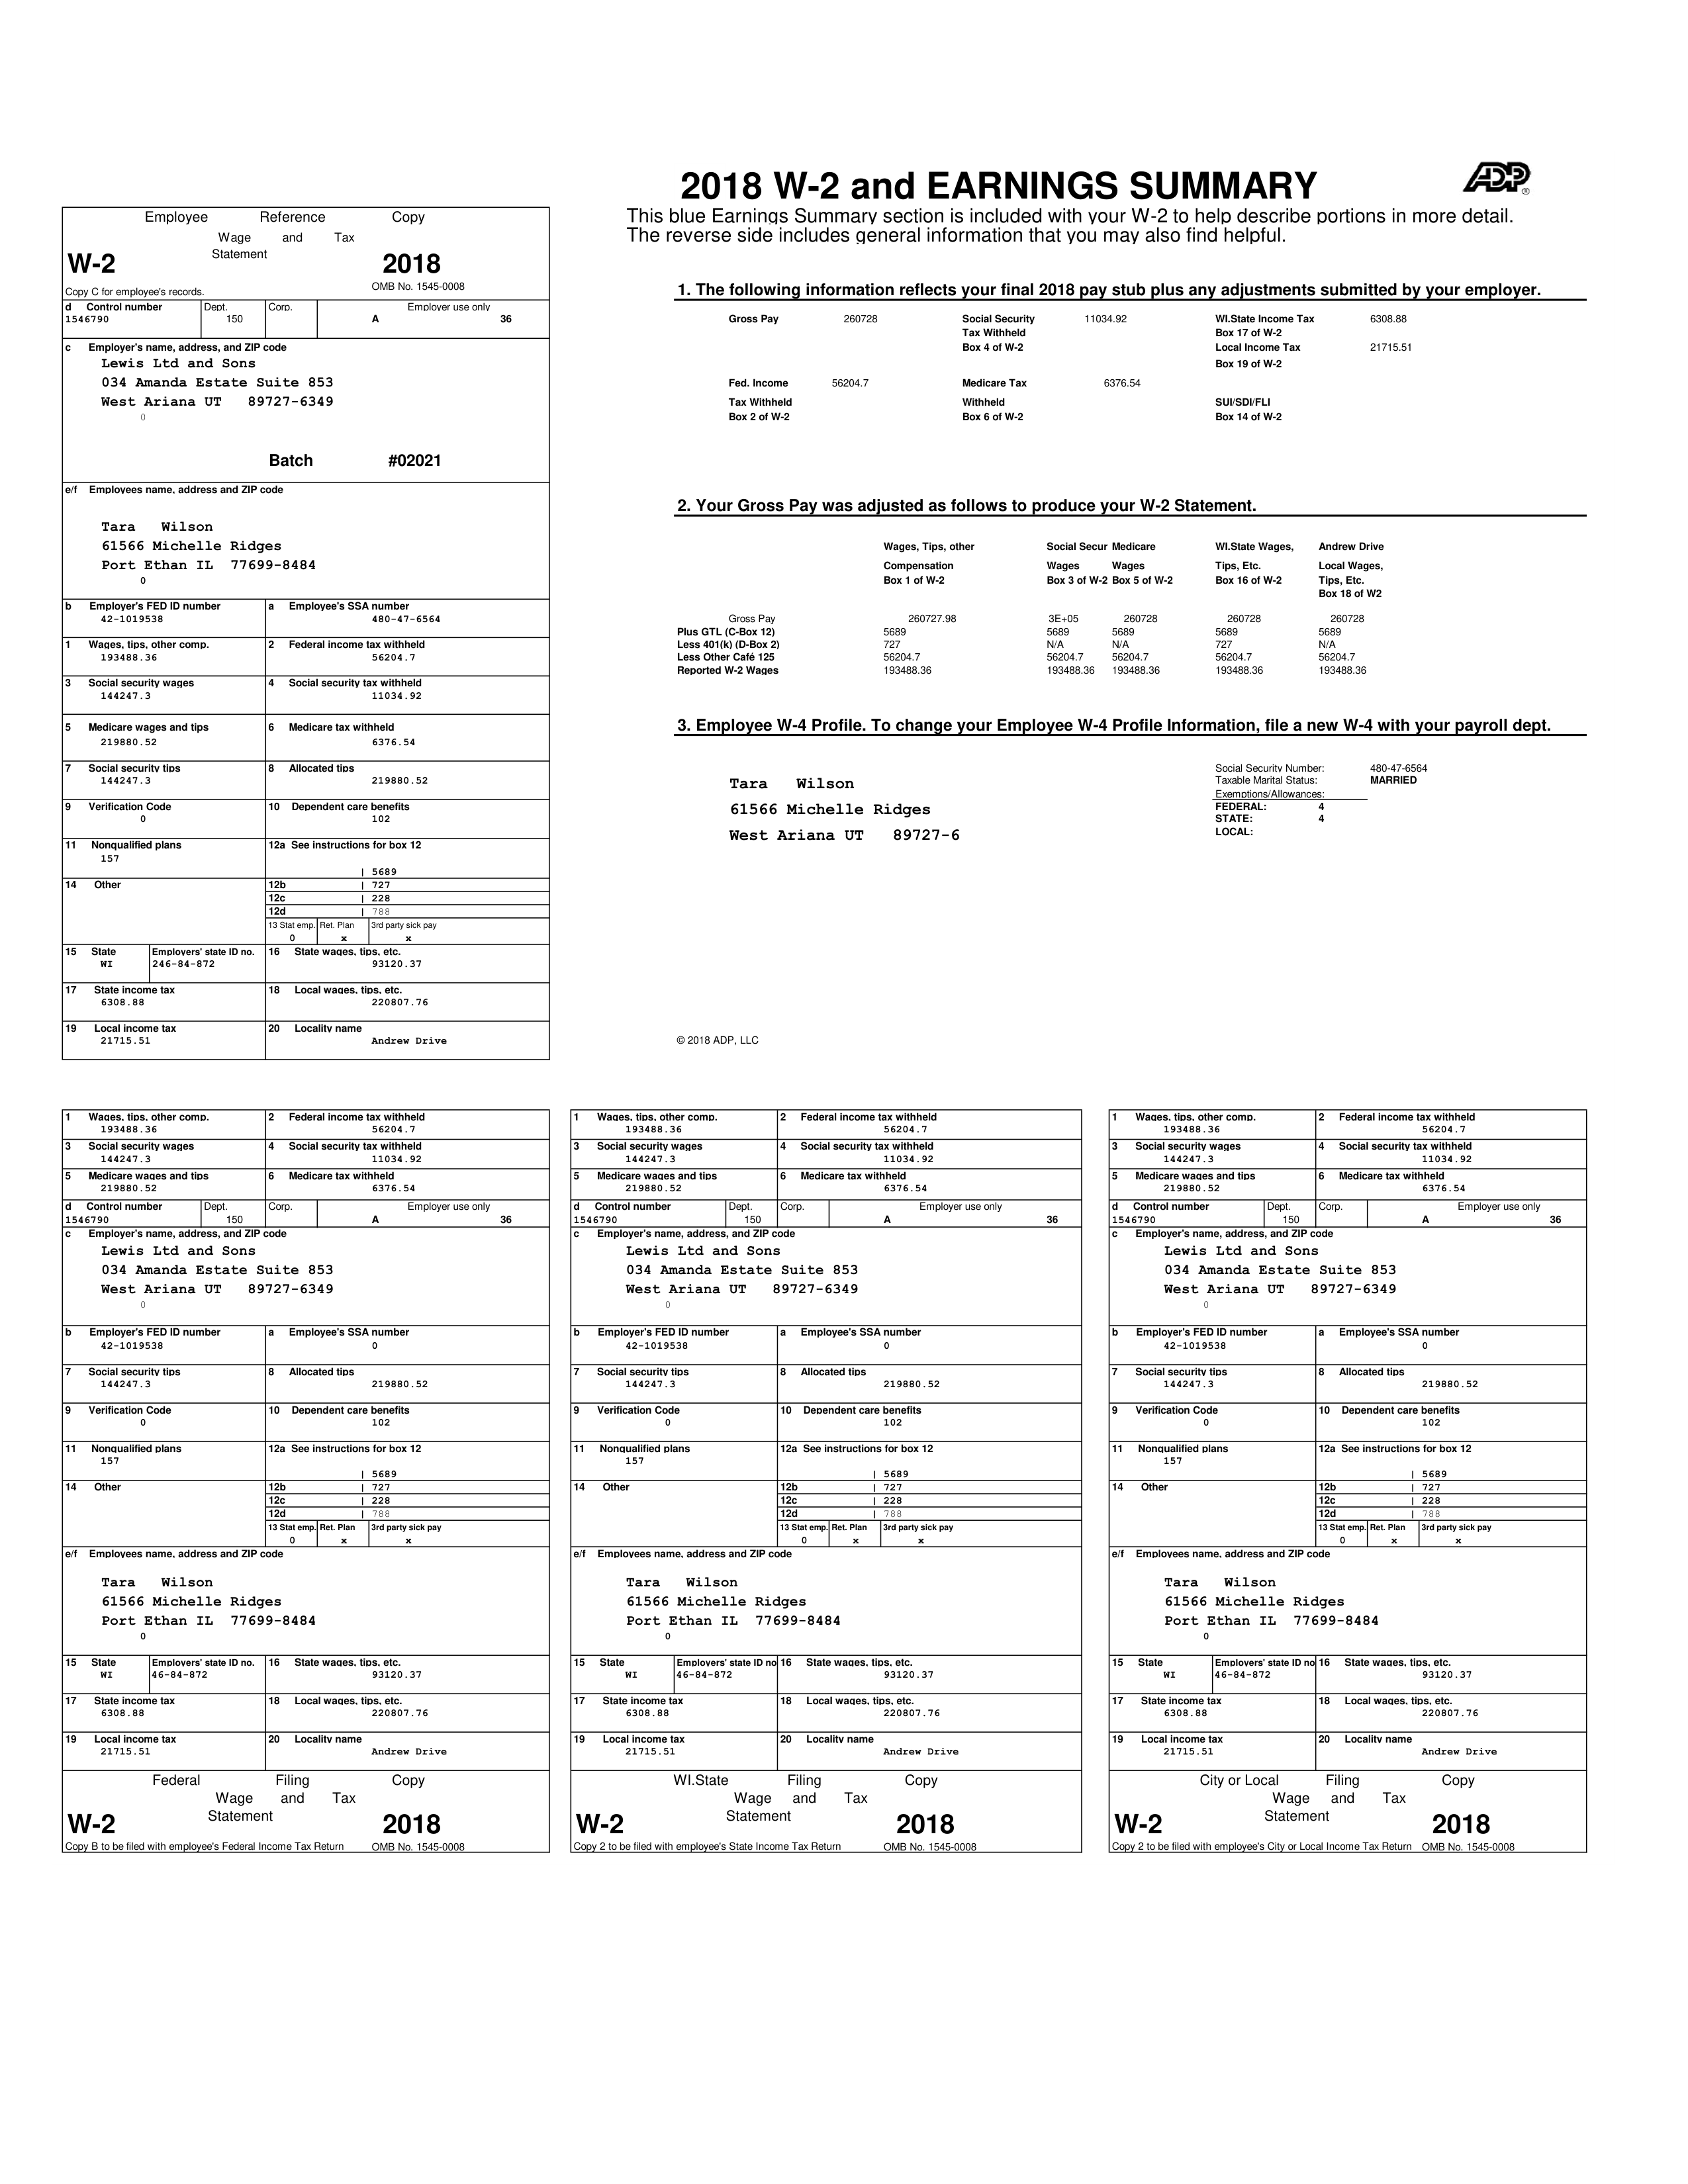

ADP2
{
    "Employee Name": "Kimberly Reed",
    "Employer Name": "Jacobson-Johnson Ltd",
    "Wages and Tips": "111650.02",
    "Federal Income Tax Withheld": "11522.12",
    "Social Security Wages": "87000.00",
    "Medicare Wages and Tips": "78396.00",
    "State 1": "LA",
    "State 1 Wages and Tips": "51229.27",
    "State 1 Income Tax Withheld": "5065.22",
    "State 2": "",
    "State 2 Wages and Tips": "",
    "State 2 Income Tax Withheld": ""
}


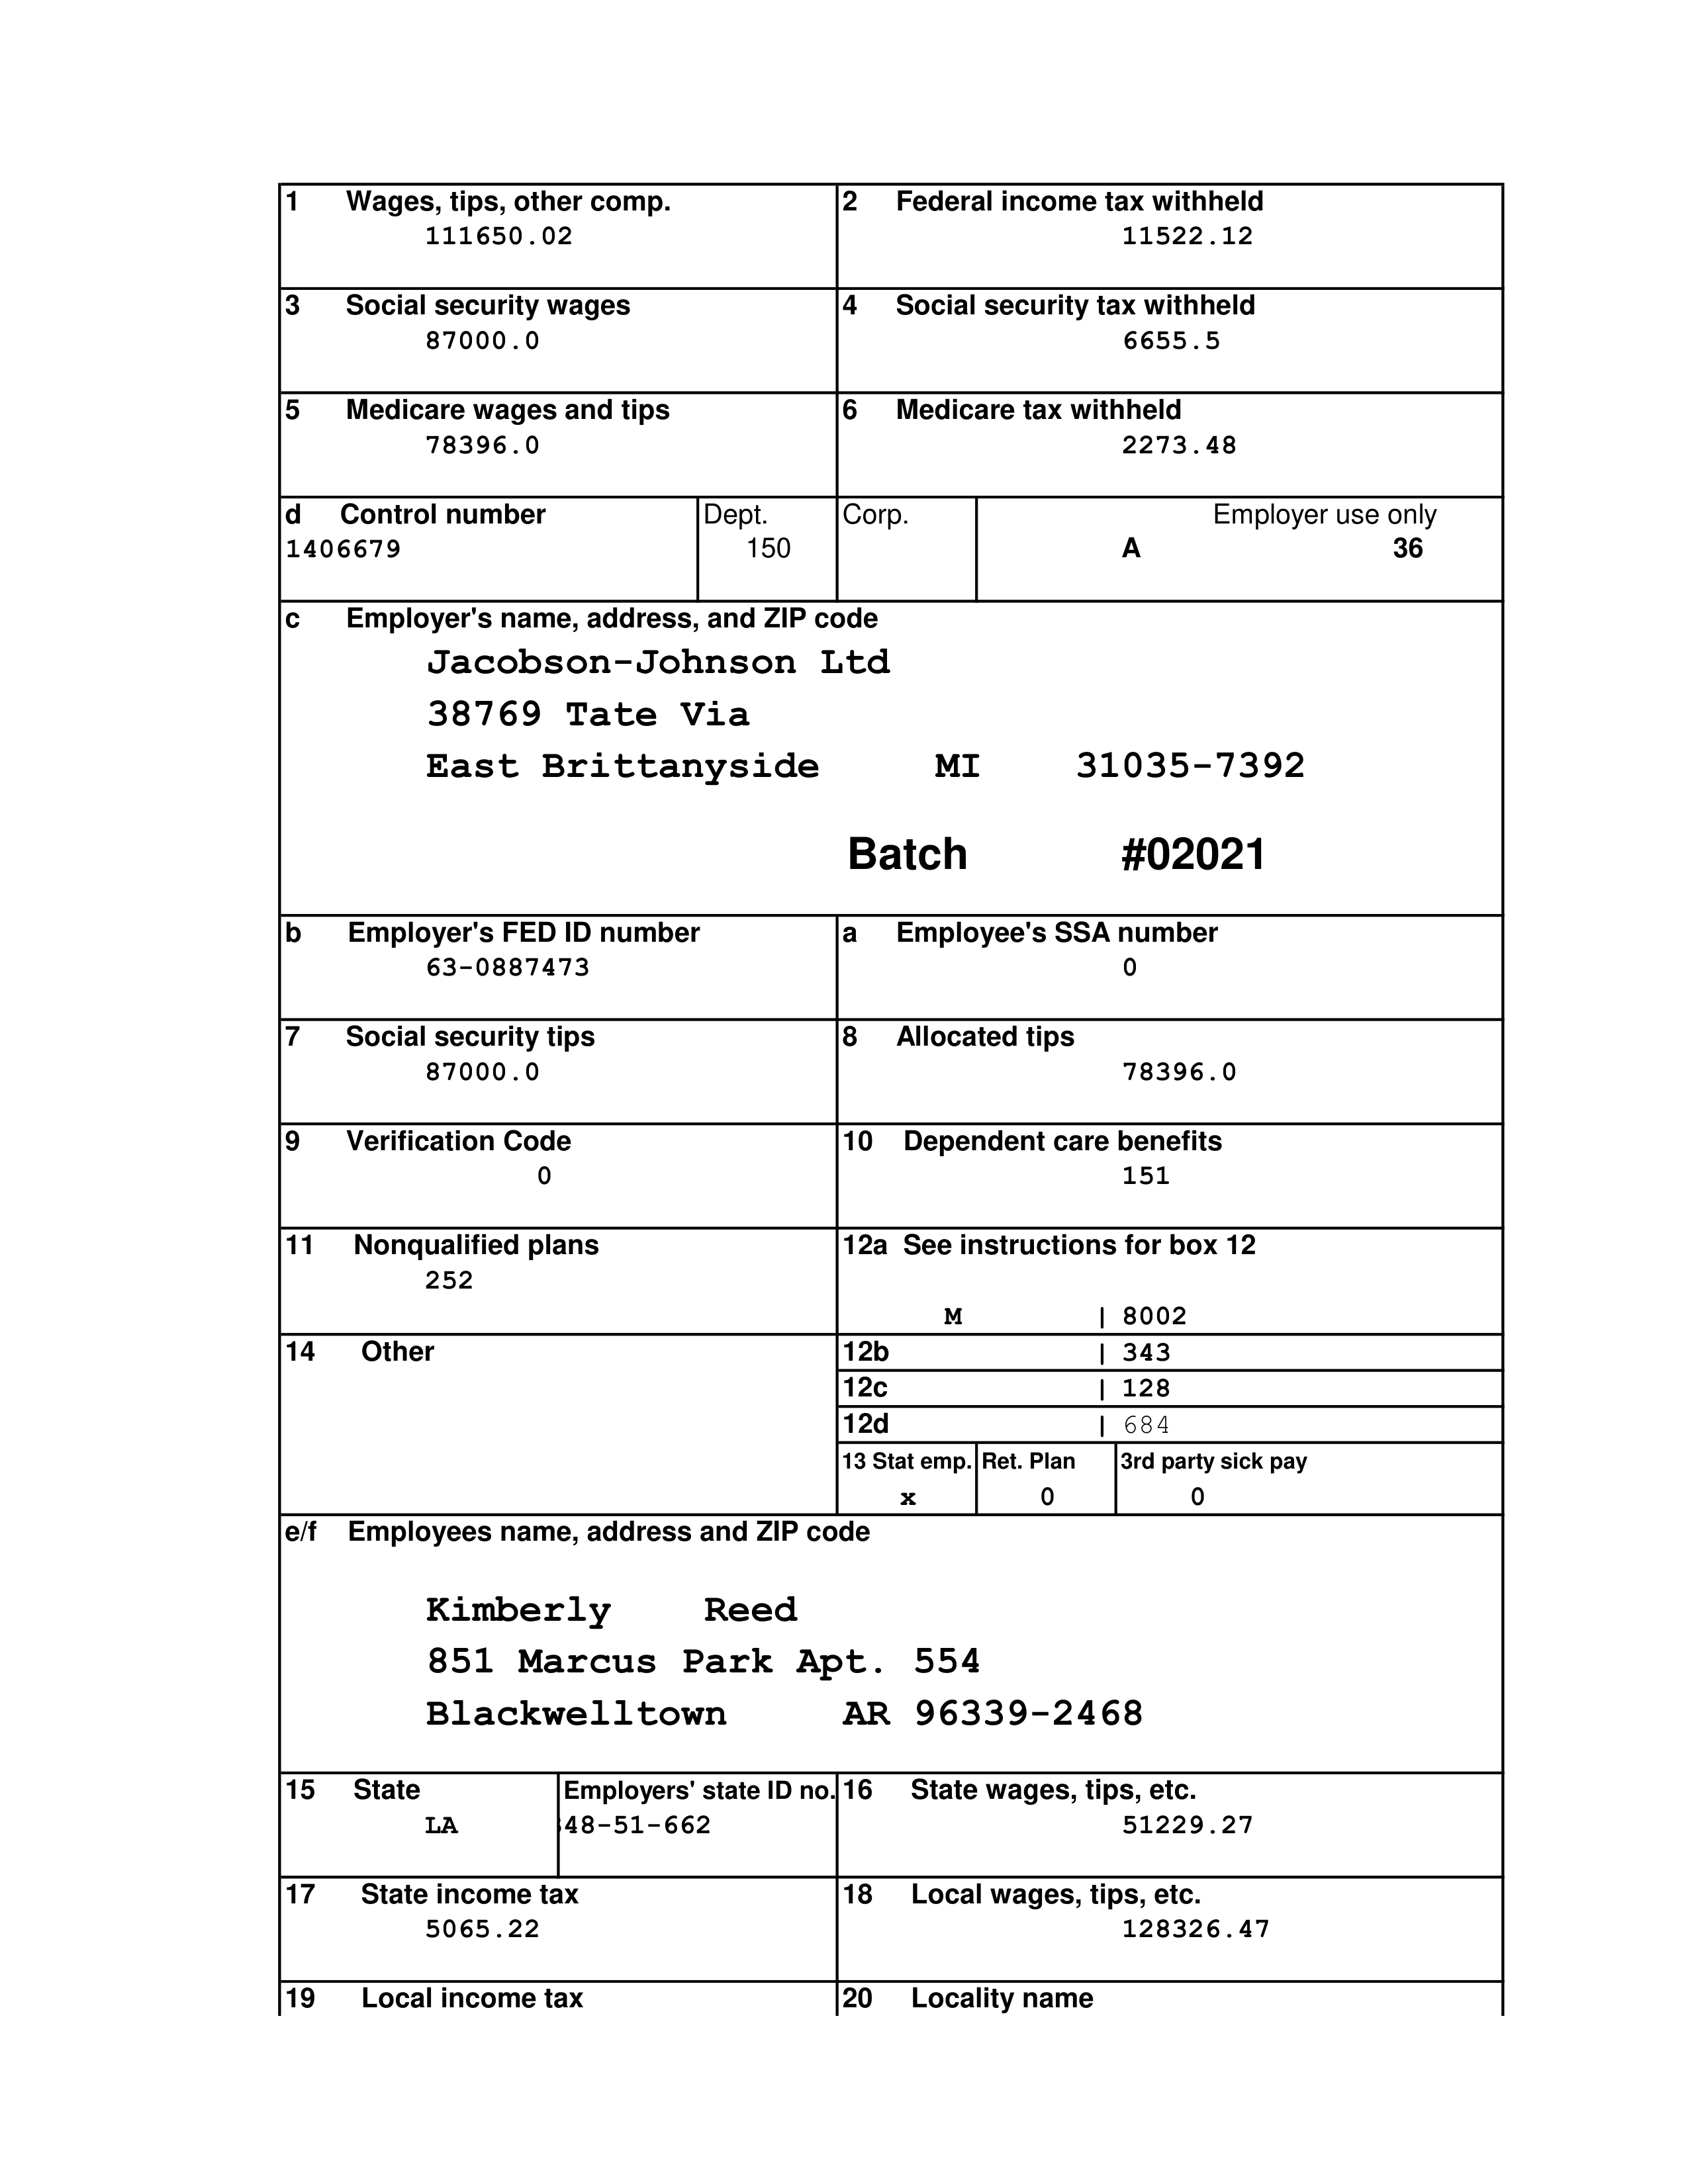

IRS1
{
    "Employee Name": "Benjamin Burch",
    "Employer Name": "Ward, Allison and Jimenez Inc",
    "Wages and Tips": "209665.25",
    "Federal Income Tax Withheld": "53423.50",
    "Social Security Wages": "272174.17",
    "Medicare Wages and Tips": "225347.99",
    "State 1": "UT",
    "State 1 Wages and Tips": "101914.73",
    "State 1 Income Tax Withheld": "6744.55",
    "State 2": "MS",
    "State 2 Wages and Tips": "111269.12",
    "State 2 Income Tax Withheld": "7135.46"
}


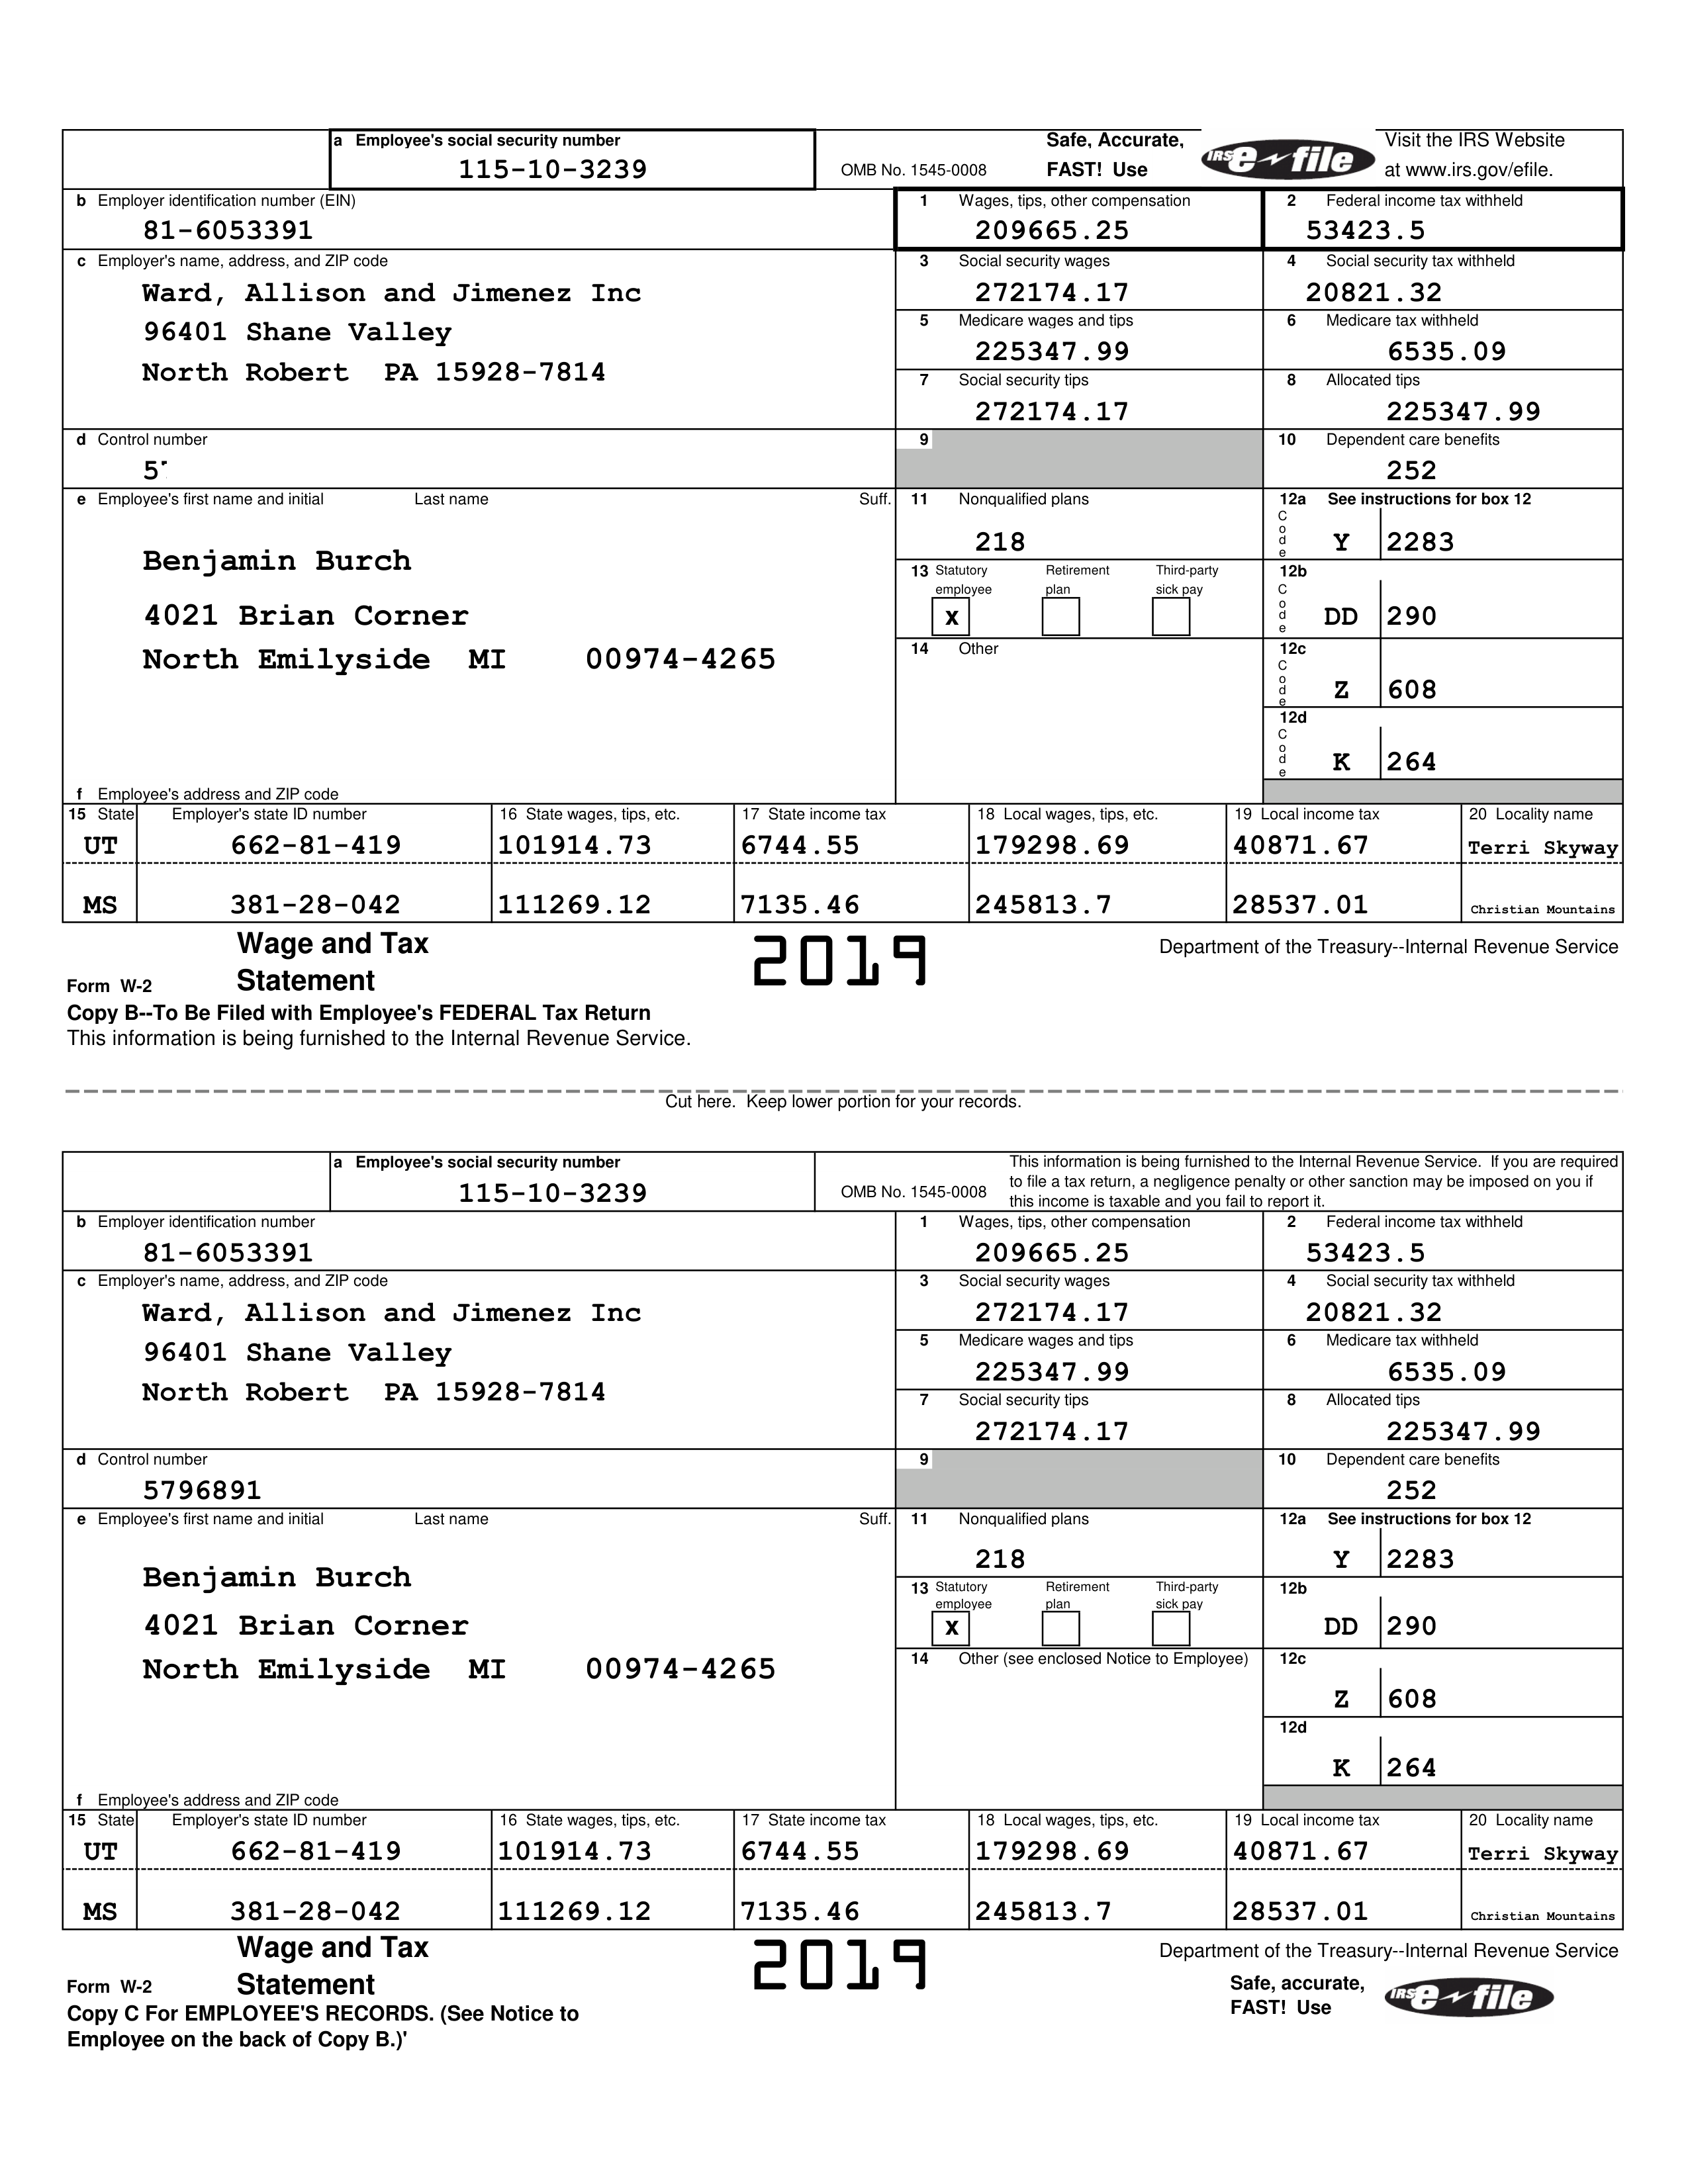

IRS2
{
    "Employee Name": "Michael Brady",
    "Employer Name": "White Group Ltd",
    "Wages and Tips": "169792.08",
    "Federal Income Tax Withheld": "19693.19",
    "Social Security Wages": "179041.17",
    "Medicare Wages and Tips": "174894.52",
    "State 1": "WA",
    "State 1 Wages and Tips": "83340.70",
    "State 1 Income Tax Withheld": "5866.21",
    "State 2": "FL",
    "State 2 Wages and Tips": "78263.06",
    "State 2 Income Tax Withheld": "6178.72"
}


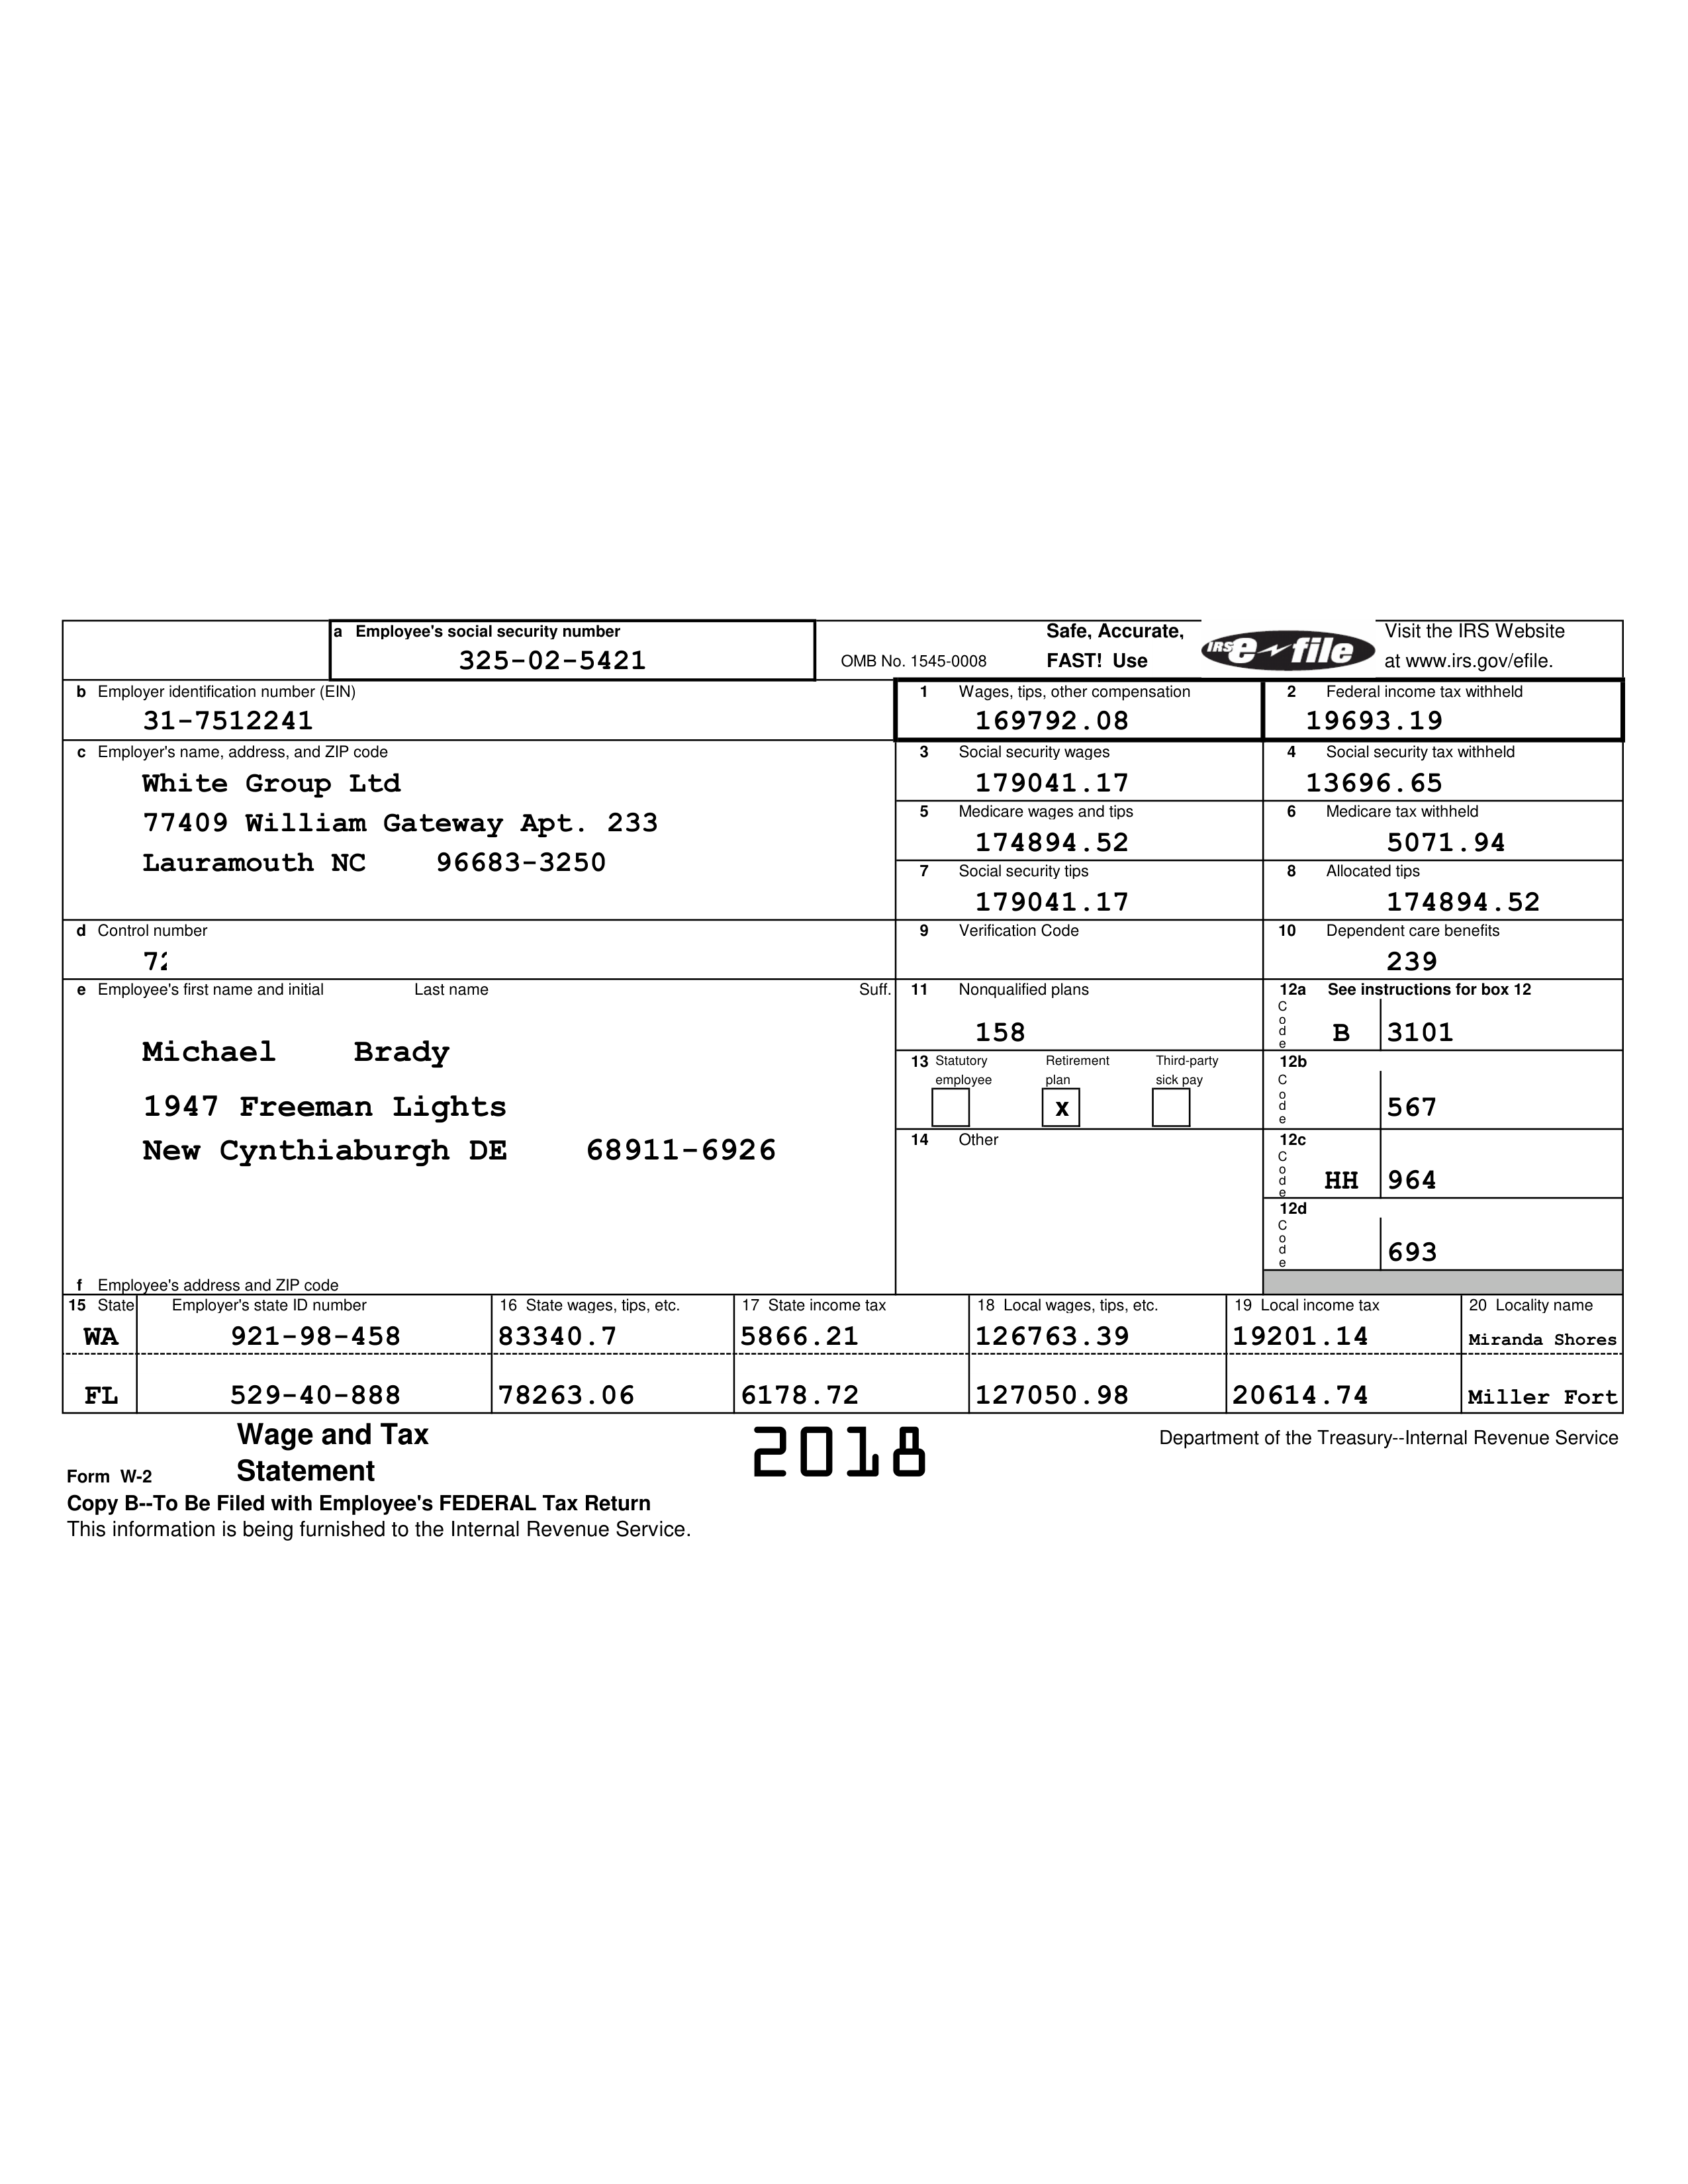

In [68]:
# read cleaned metadata file
ground_truth_examples = file.read_jsonl(dataset_processed_labels_file)

# output first ADP1 example
file_name, example = ground_truth_examples[0]
print("ADP1")
print(json.dumps(example, indent=4))
display(Image(filename=f"{dataset_processed_images_dir}/{file_name}"))

# output first ADP2 example
file_name, example = ground_truth_examples[250]
print("ADP2")
print(json.dumps(example, indent=4))
display(Image(filename=f"{dataset_processed_images_dir}/{file_name}"))

# output first IRS1 example
file_name, example = ground_truth_examples[500]
print("IRS1")
print(json.dumps(example, indent=4))
display(Image(filename=f"{dataset_processed_images_dir}/{file_name}"))

# output first IRS2 example
file_name, example = ground_truth_examples[750]
print("IRS2")
print(json.dumps(example, indent=4))
display(Image(filename=f"{dataset_processed_images_dir}/{file_name}"))

Now split the ground truth metadata and image files into train, validation, and test datasets. We'll use this later for training.

In [69]:
# Set a random seed for reproducibility
random.seed(random_state)

# Define paths (adjust these based on your setup)
metadata_file_path = dataset_processed_labels_file
image_dir = dataset_processed_images_dir
output_dir = dataset_processed_final_dir

# Define form type index ranges
form_types = {
    "ADP1": (0, 249),
    "ADP2": (250, 499),
    "IRS1": (500, 749),
    "IRS2": (750, 999),
}

# Split ratios
train_ratio = 0.8  # 80% train
val_ratio = 0.1  # 10% validation
test_ratio = 0.1  # 10% test

# Step 1: Load metadata
with open(metadata_file_path, "r") as f:
    metadata = [json.loads(line) for line in f]

# Step 2: Group metadata by form type
form_metadata = {form: [] for form in form_types}
for i, entry in enumerate(metadata):
    for form_type, (start, end) in form_types.items():
        if start <= i <= end:
            form_metadata[form_type].append(entry)
            break


# Step 3: Function to split data for a form type
def split_data(data, train_ratio, val_ratio, test_ratio):
    random.shuffle(data)  # Randomize the samples
    total = len(data)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    test_end = val_end + int(total * test_ratio)
    return data[:train_end], data[train_end:val_end], data[val_end:test_end]


# Step 4: Split each form type’s data
train_data, val_data, test_data = [], [], []
for form_type in form_types:
    form_train, form_val, form_test = split_data(
        form_metadata[form_type], train_ratio, val_ratio, test_ratio
    )
    train_data.extend(form_train)
    val_data.extend(form_val)
    test_data.extend(form_test)


# Step 5: Function to process each split (copy images and write metadata)
def process_split(split_data, split_name):
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)  # Create directory if it doesn’t exist
    metadata_path = os.path.join(split_dir, "metadata.jsonl")

    # sort data split by filename (so it matches file ordering)
    sorted_split_data = sorted(split_data, key=lambda x: x["file_name"])

    with open(metadata_path, "w") as f:
        for entry in sorted_split_data:
            # Write metadata entry
            f.write(json.dumps(entry) + "\n")
            # Copy image to split directory
            image_name = entry["file_name"]  # Relies on 'file_name' key in metadata
            src_path = os.path.join(image_dir, image_name)
            dest_path = os.path.join(split_dir, image_name)
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)
            else:
                print(f"Warning: Image {src_path} not found.")


# Step 6: Process each split
process_split(train_data, "train")
process_split(val_data, "val")
process_split(test_data, "test")

print(
    "Dataset successfully split into train, val, and test with equal form type distribution."
)

Dataset successfully split into train, val, and test with equal form type distribution.
